In [1]:
import numpy as np 
import pandas as pd

from darts.models import TCNModel
from darts.utils.callbacks import TFMProgressBar
import darts.utils.timeseries_generation as tg
from darts.utils.likelihood_models import GaussianLikelihood, QuantileRegression
from darts.utils.missing_values import fill_missing_values
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts import concatenate
from darts.datasets import EnergyDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import torch 
from sklearn.model_selection import train_test_split
from data_process import get_data_loaders, getFeatures, create_sequences

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

import matplotlib.pyplot as plt


def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

/Users/lianyang/Desktop/UMich/Fall 2023/EECS 553/Project/venv/lib/python3.10/site-packages/statsforecast/core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
data =pd.read_csv("flights.csv")

data = get_data_loaders(data, covariates=True)[0]
features = getFeatures()

#flight_data = data[data["flight"] == 2]

flight_data = data
flight_data.index = pd.date_range(start='2000-01-01', periods=len(flight_data), freq='S')
future_covariants_df = flight_data[['x_future', 'y_future', 'z_future']]
flight_data = flight_data.drop(['x_future', 'y_future', 'z_future'], axis=1)

In [11]:
future_covariates = TimeSeries.from_dataframe(future_covariants_df.astype('float32'))
train_future_covariates, val_future_covariates = future_covariates.split_before(0.8)


In [4]:
# Select target and features
target = 'energy_consumed'  # Assuming 'energy_consumed' is the column you want to predict
features = flight_data.columns.drop(['flight', 'time', target])  # Drop non-feature columns

# Create TimeSeries objects for target and features, ensuring dtype is float32
target_series = TimeSeries.from_series(flight_data[target].astype('float32'))
feature_series = [TimeSeries.from_series(flight_data[feature].astype('float32')) for feature in features]

# Concatenate all feature series into one (if needed)
feature_series = concatenate(feature_series, axis=1)

# Split the data into training and test sets
train_target_series, val_target_series = target_series.split_before(0.8)
train_feature_series, val_feature_series = feature_series.split_before(0.8)

In [5]:
val_target_series

<TimeSeries (DataArray) (time: 50200, component: 1, sample: 1)>
array([[[0.1011619 ]],

       [[0.10147329]],

       [[0.1017877 ]],

       ...,

       [[0.40888712]],

       [[0.40888873]],

       [[0.40889263]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-03T07:46:35 ... 2000-01-03T21:43:14
  * component  (component) object 'energy_consumed'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='time'>

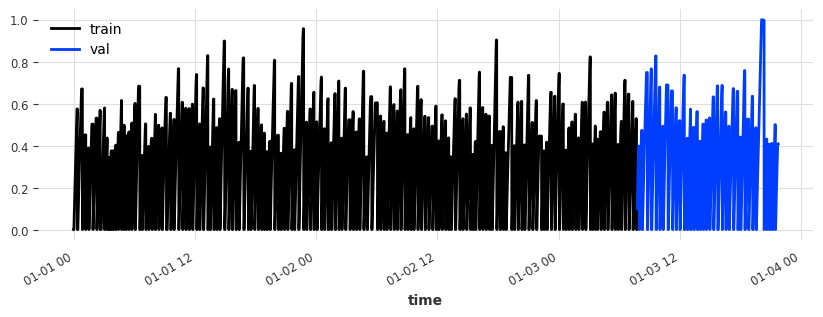

In [6]:
plt.figure(figsize=(10, 3))
train_target_series.plot(label='train')
val_target_series.plot(label='val')

In [7]:
# add the day as a covariate (no scaling required, as one-hot-encoded)
# day_series = datetime_attribute_timeseries(
#     series_en_transformed, attribute="day", one_hot=True
# )

# Assume input_seq_len and output_seq_len are defined
# model = TCNModel(
#     input_chunk_length=10,
#     output_chunk_length=2,
#     n_epochs=100,  # Or any other number of epochs
#     dropout=0.2,
#     batch_size=64,
#     optimizer_kwargs={"lr": 0.001},
#     random_state=42,
#     likelihood=QuantileRegression(),
#     model_name="TCN_flight",
#     save_checkpoints=True,
#     force_reset=True
# )

model = TCNModel(
    input_chunk_length=30,  # Adjust based on your data's temporal dynamics
    output_chunk_length=5,  # Adjust based on how far you want to predict into the future
    n_epochs=20,
    dropout=0.1,  # Try a lower dropout
    batch_size=32,  # Adjust based on your data size and training speed
    optimizer_kwargs={"lr": 0.001},  # You might want to try a smaller learning rate if loss increases
    random_state=42,
    model_name="TCN_flight",
    save_checkpoints=True,
    force_reset=True,
    num_filters=2,  # Adjust the complexity of the model
    kernel_size=3   # Adjust based on your temporal sequence patterns
    # Remove likelihood if you want to try deterministic forecasting
)

# Fit the model
model.fit(series=train_target_series, 
          past_covariates=train_feature_series,
          val_series=val_target_series,
          val_past_covariates=val_feature_series,
          verbose=True,
          epochs=20)

# Evaluate the model
backtest = model.historical_forecasts(
    series=val_target_series,
    past_covariates=val_feature_series,
    forecast_horizon=2,  # This should match your `output_chunk_length`
    stride=1,
    retrain=False,
    verbose=True
)


Predicting DataLoader 0:  30%|███       | 471/1568 [00:11<00:27, 40.58it/s]107, val_loss=0.00153]  

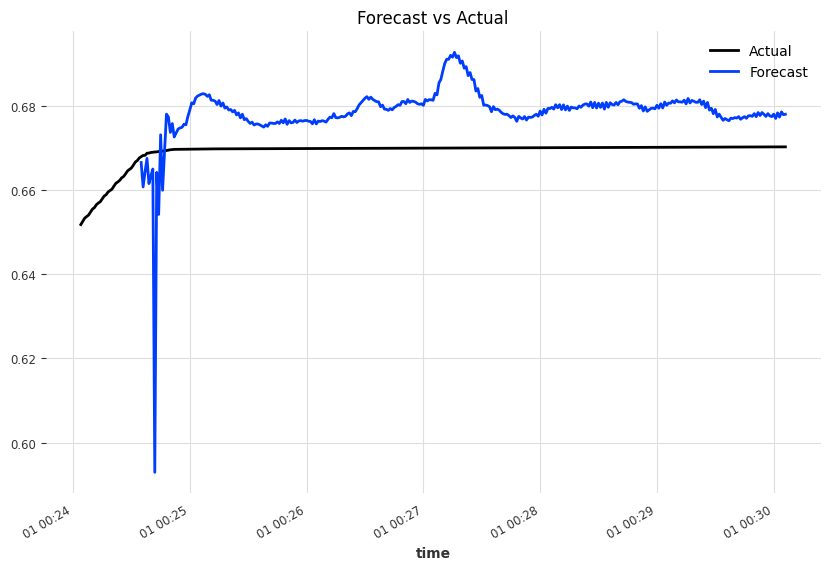

NameError: name 'val_target_scaled' is not defined

In [24]:
# Plotting the actual vs forecast
plt.figure(figsize=(10, 6))
val_target_series.plot(label="Actual")
backtest.plot(label="Forecast")
plt.title('Forecast vs Actual')
plt.legend()
plt.show()

# Calculate metrics, if needed
from darts.metrics import mae, mse

print(f'MAE: {mae(val_target_scaled, backtest)}')
print(f'MSE: {mse(val_target_scaled, backtest)}')

Epoch 2:  57%|█████▋    | 12/21 [00:00<00:00, 14.26it/s, train_loss=2.080, val_loss=3.360]

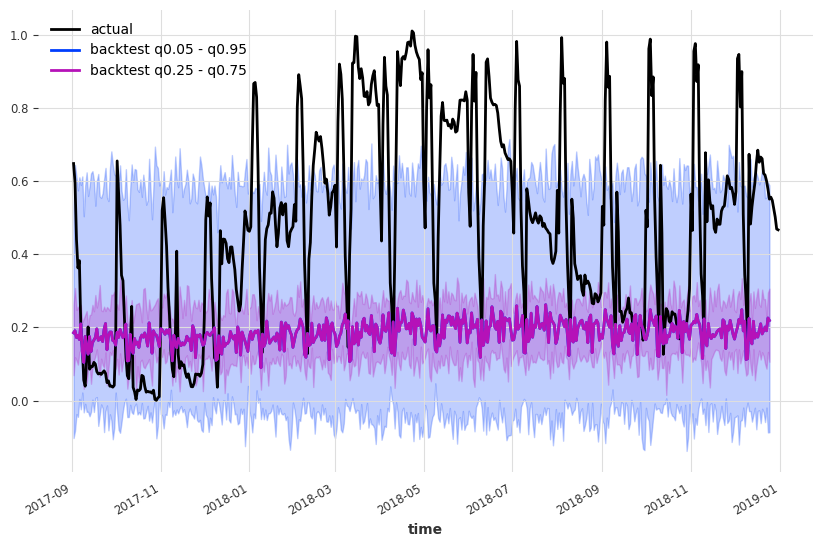

In [33]:
df3 = EnergyDataset().load().pd_dataframe()
df3_day_avg = (
    df3.groupby(df3.index.astype(str).str.split(" ").str[0]).mean().reset_index()
)
series_en = fill_missing_values(
    TimeSeries.from_dataframe(
        df3_day_avg, "time", ["generation hydro run-of-river and poundage"]
    ),
    "auto",
)

# scale
scaler_en = Scaler()
train_en, val_en = series_en.split_after(pd.Timestamp("20170901"))
train_en_transformed = scaler_en.fit_transform(train_en)
val_en_transformed = scaler_en.transform(val_en)
series_en_transformed = scaler_en.transform(series_en)

# add the day as a covariate (no scaling required, as one-hot-encoded)
day_series = datetime_attribute_timeseries(
    series_en_transformed, attribute="day", one_hot=True
)

plt.figure(figsize=(10, 3))
train_en_transformed.plot(label="train")
val_en_transformed.plot(label="validation")

model_name = "TCN_test"
deeptcn = TCNModel(
    dropout=0.2,
    batch_size=32,
    n_epochs=50,
    optimizer_kwargs={"lr": 1e-3},
    random_state=0,
    input_chunk_length=300,
    output_chunk_length=30,
    kernel_size=3,
    num_filters=4,
    likelihood=QuantileRegression(),
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    **generate_torch_kwargs(),
)

deeptcn.fit(
    series=train_en_transformed,
    past_covariates=day_series,
    val_series=val_en_transformed,
    val_past_covariates=day_series,
)

deeptcn = TCNModel.load_from_checkpoint(model_name=model_name, best=True)

backtest_en = deeptcn.historical_forecasts(
    series=series_en_transformed,
    start=val_en_transformed.start_time(),
    past_covariates=day_series,
    num_samples=500,
    forecast_horizon=30,
    stride=30,
    last_points_only=False,
    retrain=False,
    verbose=True,
)
backtest_en = concatenate(backtest_en)

plt.figure(figsize=(10, 6))
val_en_transformed.plot(label="actual")
backtest_en.plot(label="backtest q0.05 - q0.95", low_quantile=0.05, high_quantile=0.95)
backtest_en.plot(label="backtest q0.25 - q0.75", low_quantile=0.25, high_quantile=0.75)
plt.legend()